In [1]:
import polars as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error
import pickle

import sys
import os

# Add the root project directory to the Python path
sys.path.append(os.path.abspath(".."))

from scripts.functions import read_dataframe, one_hot_encoding, train_model

In [2]:
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("nyc-taxi-experiment")


<Experiment: artifact_location='mlflow-artifacts:/712286886036284170', creation_time=1747060237229, experiment_id='712286886036284170', last_update_time=1747060237229, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
# ingest the data from the NYC Taxi Data website
# fetch the data from the URL instead of downloading it
green_tripdata_2021_01 = pl.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
green_tripdata_2021_02 = pl.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

In [4]:
january_data_green, df_train, categorical_features = read_dataframe(green_tripdata_2021_01)
february_data_green, df_val, categorical_features = read_dataframe(green_tripdata_2021_02)

print(f"len(df_train): {len(df_train)}, len(df_val): {len(df_val)}")

# if we look at the percentiles, we see that most of the trips are within 1 hour
# so it makes sense to focus on them
january_data_green["duration_minutes"].describe(percentiles=[0.95, 0.98, 0.99])

df_train

len(df_train): 73833, len(df_val): 61889


VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,duration_minutes,PU_DO
i64,datetime[ns],datetime[ns],str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,null,f64,f64,f64,f64,f64,i64,f64,str
2,2021-01-01 00:15:56,2021-01-01 00:19:52,"""N""",1.0,"""43""","""151""",1.0,1.01,5.5,0.5,0.5,0.0,0.0,null,0.3,6.8,2.0,1.0,0.0,236,3.933333,"""43_151"""
2,2021-01-01 00:25:59,2021-01-01 00:34:44,"""N""",1.0,"""166""","""239""",1.0,2.53,10.0,0.5,0.5,2.81,0.0,null,0.3,16.86,1.0,1.0,2.75,525,8.75,"""166_239"""
2,2021-01-01 00:45:57,2021-01-01 00:51:55,"""N""",1.0,"""41""","""42""",1.0,1.12,6.0,0.5,0.5,1.0,0.0,null,0.3,8.3,1.0,1.0,0.0,358,5.966667,"""41_42"""
2,2020-12-31 23:57:51,2021-01-01 00:04:56,"""N""",1.0,"""168""","""75""",1.0,1.99,8.0,0.5,0.5,0.0,0.0,null,0.3,9.3,2.0,1.0,0.0,425,7.083333,"""168_75"""
2,2021-01-01 00:26:31,2021-01-01 00:28:50,"""N""",1.0,"""75""","""75""",6.0,0.45,3.5,0.5,0.5,0.96,0.0,null,0.3,5.76,1.0,1.0,0.0,139,2.316667,"""75_75"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2021-01-31 21:38:00,2021-01-31 22:16:00,null,null,"""81""","""90""",null,17.63,56.23,2.75,0.0,0.0,6.12,null,0.3,65.4,null,null,null,2280,38.0,"""81_90"""
2,2021-01-31 22:43:00,2021-01-31 23:21:00,null,null,"""35""","""213""",null,18.36,46.66,0.0,0.0,12.2,6.12,null,0.3,65.28,null,null,null,2280,38.0,"""35_213"""
2,2021-01-31 22:16:00,2021-01-31 22:27:00,null,null,"""74""","""69""",null,2.5,18.95,2.75,0.0,0.0,0.0,null,0.3,22.0,null,null,null,660,11.0,"""74_69"""


/var/folders/w8/jf3gk0856r1_y4pft74pf1v00000gn/T/ipykernel_36642/2354924393.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(january_data_green["duration_minutes"])


<Axes: xlabel='duration_minutes', ylabel='Density'>

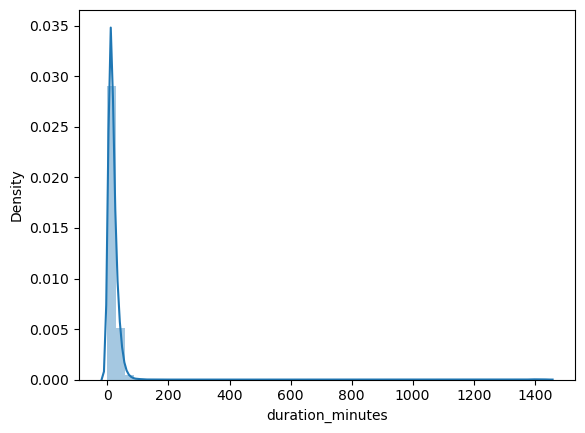

In [5]:
sns.distplot(january_data_green["duration_minutes"])


/var/folders/w8/jf3gk0856r1_y4pft74pf1v00000gn/T/ipykernel_36642/2556686641.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["duration_minutes"])


<Axes: xlabel='duration_minutes', ylabel='Density'>

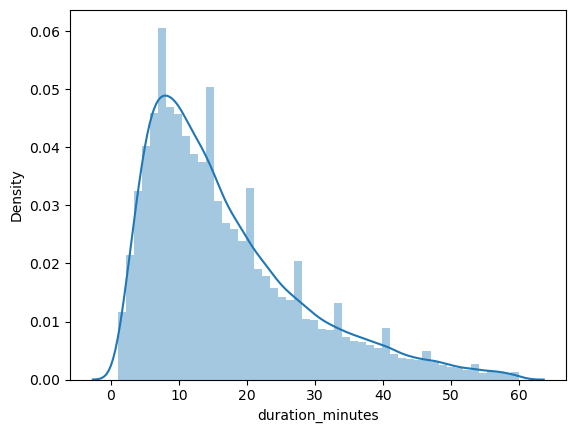

In [6]:
sns.distplot(df_train["duration_minutes"])


In [7]:
# Feature engineering
categorical_features = ["PU_DO"]
numerical_features = ["trip_distance"]
target = "duration_minutes"

X_train, X_val, dict_vectorizer = one_hot_encoding(df_train, df_val, categorical_features, numerical_features)
y_train, y_val = df_train[target], df_val[target]


/Users/jucikisistok/Documents/dev/mlops-zoomcamp/scripts/functions.py:69: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/Users/jucikisistok/Documents/dev/mlops-zoomcamp/scripts/functions.py:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


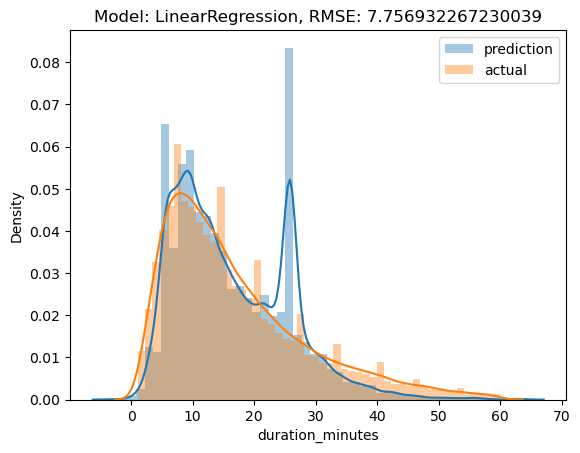

In [8]:
lr = train_model(LinearRegression(), X_train, y_train, X_val, y_val)


In [9]:
# save this model
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dict_vectorizer, lr), f_out)

# load the model
# with open("models/lin_reg.bin", "rb") as f_in:
#     dict_vectorizer, lr = pickle.load(f_in)

/Users/jucikisistok/Documents/dev/mlops-zoomcamp/scripts/functions.py:69: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/Users/jucikisistok/Documents/dev/mlops-zoomcamp/scripts/functions.py:70: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


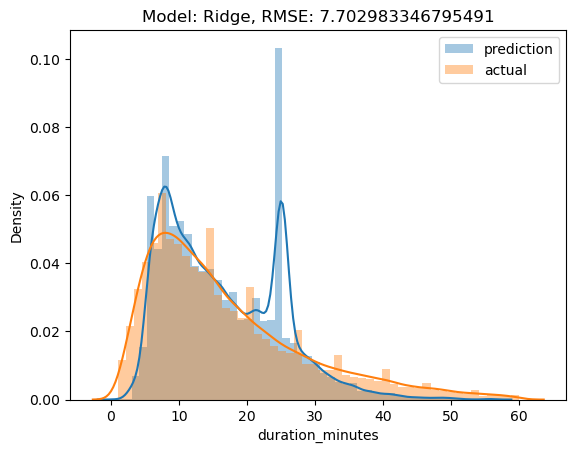

In [ ]:
with mlflow.start_run():
    # tag the run with the developer's name
    mlflow.set_tag("developer", "judit")
    # log the dataset being used
    mlflow.log_param("train-data-url", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-url", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    
    alpha = 0.01
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)